In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import networkx as nx
from itertools import combinations
from typing import List, Set, Tuple

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
    "rec.sport.hockey",
    "soc.religion.christian"
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="train",
    categories=categories,
    shuffle=True,
    random_state=42,
)

org_data = []
labels = []

indices = np.arange(len(dataset.target))
np.random.shuffle(indices)
org_data = np.array(dataset.data)[indices[:300]]
labels = dataset.target[indices[:300]]
# for i in range(len(categories)):
#     indices = np.where(dataset.target == i)[0]
#     np.random.shuffle(indices)
#     indices = indices[:140]
#     org_data.extend(np.array(dataset.data)[indices])
#     labels.extend(dataset.target[indices])
    

org_data = np.array(org_data)
labels = np.array(labels)
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(org_data)} documents - {true_k} categories")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


300 documents - 6 categories


In [2]:
org_data[4]

'\n\n\n\t\t\t\t\tPardon me, a humble atheist, but exactly what is the difference\nbetween holding a revealed truth with blind faith as its basis (i.e.\nregardless of any evidence that you may find to the contrary) as an\nabsolute truth, fully expecting people to believe you and arrogance?\n\n     They sound like one and the same to me.\n\n     And nearly every time I meet a christian (or for that matter, any\nother theist) who tries to convert me, I find this proven over and over\nagain.\n\n     I see no wisdom whatsoever in your words\n\n\n                                       Unfaithfully yours,\n\n                                       Pixie\n\n\n     p.s.  If you do sincerely believe that a god exists, why do you follow\nit blindly?  \n\n     Do the words "Question Authority" mean anything to you?'

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=4,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(org_data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.077 s
n_samples: 300, n_features: 1342


In [4]:
data = np.array(X_tfidf.todense())
n_samples, n_features = data.shape

In [5]:
n_samples, n_features

(300, 1342)

Text(0.5, 0, 'features')

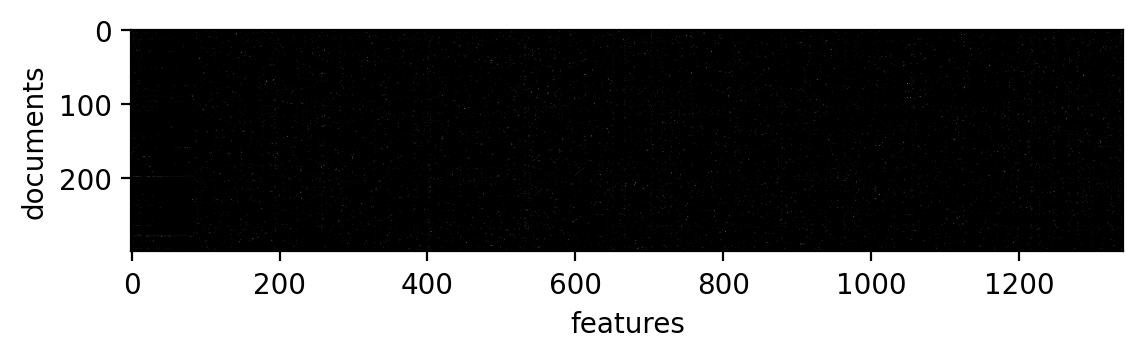

In [6]:
plt.figure(dpi = 200)
plt.imshow(data, cmap = "gray")
plt.ylabel("documents")
plt.xlabel("features")

In [7]:
def row_normalization(data: np.array) -> np.array:
    row_average = data.mean(axis = 0)[None, :]
    centered_data = data - row_average
    normalized_length = centered_data / np.linalg.norm(centered_data, axis=1)[:, None]
    return normalized_length

def column_normalization(data: np.array) -> np.array:
    column_average = data.mean(axis = 1)[:, None]
    centered_data = data - column_average
    normalized_length = centered_data / np.linalg.norm(centered_data, axis = 0)[None, :]
    return normalized_length


def vector_to_set(vector: np.ndarray) -> Set[int]:
    """
    Convert a binary or weighted vector to a set of indices with non-zero values.

    Parameters:
    - vector: 1D NumPy array.

    Returns:
    - Set of indices where the vector has non-zero values.
    """
    return set(np.nonzero(vector)[0])

def jaccard_similarity(set1: Set[int], set2: Set[int]) -> float:
    """
    Compute the Jaccard similarity between two sets.

    Parameters:
    - set1: First set.
    - set2: Second set.

    Returns:
    - Jaccard similarity as a float.
    """
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

def fuse_fixed_points_vectors(
    feature_vectors: np.ndarray,
    sample_vectors: np.ndarray,
    similarity_threshold: float = 0.7
) -> Tuple[List[Set[int]], List[Set[int]]]:
    """
    Fuse similar fixed points based on their feature and sample vectors.

    Parameters:
    - feature_vectors: 2D NumPy array where each row represents a feature vector for a fixed point.
                       Columns correspond to features.
    - sample_vectors: 2D NumPy array where each row represents a sample vector for a fixed point.
                      Columns correspond to samples.
    - similarity_threshold: Threshold above which fixed points are considered similar.

    Returns:
    - fused_features_list: List of sets, each representing fused features in a module.
    - fused_samples_list: List of sets, each representing fused samples in a module.
    """
    if feature_vectors.shape[0] != sample_vectors.shape[0]:
        raise ValueError("feature_vectors and sample_vectors must have the same number of fixed points (rows).")
    
    num_fixed_points = feature_vectors.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(num_fixed_points))  # Nodes are indices of fixed points

    # Precompute sets for all fixed points
    feature_sets = [vector_to_set(feature_vectors[i]) for i in range(num_fixed_points)]
    sample_sets = [vector_to_set(sample_vectors[i]) for i in range(num_fixed_points)]

    # Iterate over all unique pairs to compute similarity
    for i, j in combinations(range(num_fixed_points), 2):
        feature_sim = jaccard_similarity(feature_sets[i], feature_sets[j])
        sample_sim = jaccard_similarity(sample_sets[i], sample_sets[j])
        # Define overall similarity as the average of feature and sample similarity
        overall_sim = (feature_sim + sample_sim) / 2
        if overall_sim >= similarity_threshold:
            G.add_edge(i, j)

    # Find connected components (clusters of similar fixed points)
    clusters = list(nx.connected_components(G))

    fused_features_list = []
    fused_samples_list = []

    for cluster in clusters:
        fused_features = set()
        fused_samples = set()
        for idx in cluster:
            fused_features.update(feature_sets[idx])
            fused_samples.update(sample_sets[idx])
        fused_features_list.append(fused_features)
        fused_samples_list.append(fused_samples)

    return fused_features_list, fused_samples_list
    

def display_fused_modules(
    fused_features: List[Set[int]],
    fused_samples: List[Set[int]],
    feature_labels: List[str],
    sample_labels: List[str]
):
    """
    Display the fused modules with feature and sample labels.

    Parameters:
    - fused_features: List of sets containing feature indices.
    - fused_samples: List of sets containing sample indices.
    - feature_labels: List mapping feature indices to feature names.
    - sample_labels: List mapping sample indices to sample names.
    """
    for i, (features, samples) in enumerate(zip(fused_features, fused_samples), 1):
        feature_names = [feature_labels[idx] for idx in features]
        sample_names = [sample_labels[idx] for idx in samples]
        print(f"Fused Module {i}:")
        print(f"  Features: {sorted(feature_names)}")
        print(f"  Samples: {sorted(sample_names)}\n")

  
    
def ISA(data: np.array, n_initial: int = 1000, n_updates = 1000, thresh_feature: int = 0, thresh_sample: int = 0, fusion_similarity_threshold: float = 0.8):

    def W(x: np.array) -> np.array:
        return x

    def threshold(x: np.array, t: int) -> np.array:
        s = np.std(x)
        new_x = (x - np.mean(x))/(s if (s!=0 and not np.isinf(s)) else 1)
        return (new_x > t).astype(int)
    
    def f(x: np.array, t_feature: int = None, t_sample: int = None) -> np.array:
        return W(x) * threshold(x = x, t = t_feature) if t_feature is not None else W(x) * threshold(x = x, t = t_sample) 


    n_samples, n_features = data.shape
    
    r_data = row_normalization(data)
    c_data = column_normalization(data)

    feature_vector = np.zeros((n_features))
    sample_vector = np.zeros((n_samples))

    all_feature_vectors = []
    all_sample_vectors = []
    for _ in range(n_initial):
        seed = np.random.binomial(n = 1, p = 0.5, size = n_features)
        feature_vector = seed
        for i in range(n_updates):
            sample_vector = f(r_data.dot(feature_vector), t_sample = thresh_sample)
            feature_vector = f(c_data.T.dot(sample_vector), t_feature = thresh_feature)
            
        all_feature_vectors.append(feature_vector)
        all_sample_vectors.append(sample_vector)

    all_feature_vectors = np.array(all_feature_vectors)
    all_sample_vectors = np.array(all_sample_vectors)


    # Perform fusion
    fused_features, fused_samples = fuse_fixed_points_vectors(
        all_feature_vectors,
        all_sample_vectors,
        fusion_similarity_threshold
    )

    return fused_samples, fused_features
            

In [22]:
sample_vec, feature_vec = ISA(data, n_initial=1000, n_updates=20, thresh_feature=1.7, thresh_sample=1, fusion_similarity_threshold = 0.6 )

In [23]:
display_fused_modules(fused_features = feature_vec, fused_samples=sample_vec, feature_labels=vectorizer.get_feature_names_out(), sample_labels=labels)

Fused Module 1:
  Features: ['13', '19', '22', 'absolute', 'according', 'amazing', 'answers', 'ask', 'asked', 'based', 'belief', 'beliefs', 'believe', 'believed', 'bible', 'biblical', 'born', 'calls', 'change', 'children', 'christ', 'christian', 'christianity', 'christians', 'church', 'clearly', 'come', 'commands', 'consequences', 'convinced', 'correct', 'dead', 'destroy', 'did', 'die', 'died', 'disciples', 'disease', 'does', 'don', 'end', 'evidence', 'evil', 'example', 'exists', 'fact', 'faith', 'father', 'glory', 'god', 'good', 'gospel', 'half', 'heaven', 'holy', 'important', 'interpretation', 'islam', 'jesus', 'judge', 'just', 'lack', 'lie', 'life', 'light', 'literally', 'live', 'logic', 'lord', 'love', 'make', 'man', 'mean', 'means', 'men', 'mercy', 'muslims', 'need', 'parts', 'passage', 'paul', 'people', 'person', 'prayer', 'probable', 'prove', 'proven', 'question', 'real', 'reasoning', 'relationship', 'religion', 'rely', 'remember', 'require', 'responsibility', 'right', 'rights',

In [24]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'rec.sport.hockey',
 'sci.space',
 'soc.religion.christian',
 'talk.religion.misc']

Text(0.5, 0, 'features')

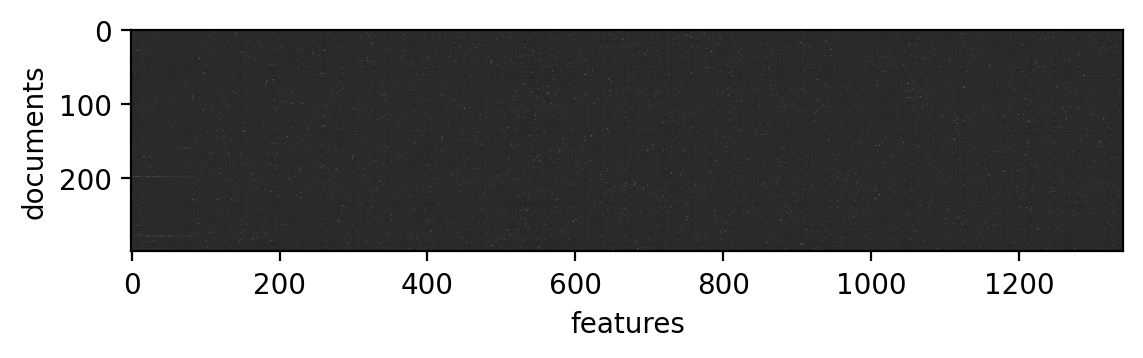

In [25]:
plt.figure(dpi = 200)
plt.imshow(row_normalization(data), cmap = "gray")
plt.ylabel("documents")
plt.xlabel("features")

Text(0.5, 0, 'features')

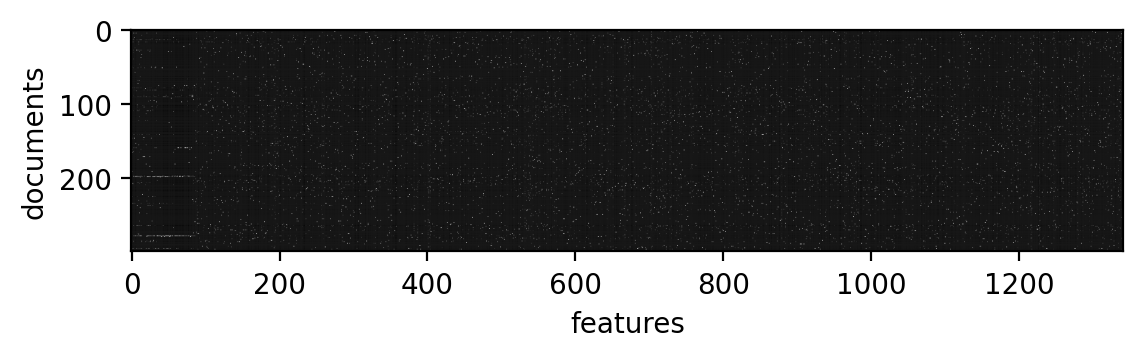

In [26]:
plt.figure(dpi = 200)
plt.imshow(column_normalization(data), cmap = "gray")
plt.ylabel("documents")
plt.xlabel("features")